### BVP

#### Codi Correu

In [6]:
## Correu
## ----- imports -----
from typing import no_type_check
import numpy as np
from scipy.signal import filtfilt, butter
from scipy.interpolate import Akima1DInterpolator
from scipy.sparse import spdiags
#from evaluation.utils import *
from scipy.signal import hilbert, periodogram


## ----- function -----
def compute_power_spectrum(signal, Fs, zero_pad=None):
    if zero_pad is not None:
        L = len(signal)
        signal = np.pad(signal, (int(zero_pad / 2 * L), int(zero_pad / 2 * L)), 'constant')
    freqs = np.fft.fftfreq(len(signal), 1 / Fs) * 60  # in bpm
    ps = np.abs(np.fft.fft(signal)) ** 2
    cutoff = len(freqs) // 2
    freqs = freqs[:cutoff]
    ps = ps[:cutoff]
    return freqs, ps


def detrend(signal, Lambda):
    """detrend(signal, Lambda) -> filtered_signal
    This function applies a detrending filter.
    This code is based on the following article "An advanced detrending method with application
    to HRV analysis". Tarvainen et al., IEEE Trans on Biomedical Engineering, 2002.
    *Parameters*
      ``signal`` (1d numpy array):
        The signal where you want to remove the trend.
      ``Lambda`` (int):
        The smoothing parameter.
    *Returns*
      ``filtered_signal`` (1d numpy array):
        The detrended signal.
    """
    signal_length = signal.shape[0]
    # observation matrix
    H = np.identity(signal_length)
    # second-order difference matrix
    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = spdiags(diags_data, diags_index, (signal_length - 2), signal_length).toarray()
    filtered_signal = np.dot((H - np.linalg.inv(H + (Lambda ** 2) * np.dot(D.T, D))), signal)

    return filtered_signal


def _next_power_of_2(x):
    """Calculate the nearest power of 2."""
    return 1 if x == 0 else 2 ** (x - 1).bit_length()


def _calculate_fft_hr(ppg_signal, fs=30, low_pass=0.75, high_pass=2.5):
    """Calculate heart rate based on PPG using Fast Fourier transform (FFT)."""
    ppg_signal = np.expand_dims(ppg_signal, 0)
    N = _next_power_of_2(ppg_signal.shape[1])
    f_ppg, pxx_ppg = periodogram(ppg_signal, fs=fs, nfft=N, detrend=False)
    fmask_ppg = np.argwhere((f_ppg >= low_pass) & (f_ppg <= high_pass))
    mask_ppg = np.take(f_ppg, fmask_ppg)
    mask_pxx = np.take(pxx_ppg, fmask_ppg)
    fft_hr = np.take(mask_ppg, np.argmax(mask_pxx, 0))[0] * 60
    return fft_hr, pxx_ppg, f_ppg


def predict_heart_rate(signal, Fs, min_hr=40., max_hr=180., method='FFT', post_preprocessing=False):
    if post_preprocessing:
        # [b, a] = butter(1, [0.5 / Fs * 2, 3 / Fs * 2], btype='bandpass')
        # signal = filtfilt(b, a, np.double(signal))
        # signal = detrend(signal, 100)
        [b, a] = butter(1, [0.5 / Fs * 2, 3.3 / Fs * 2], btype='bandpass')
        signal = filtfilt(b, a, np.double(signal))
        signal = detrend(signal, 100)
    if method == 'FFT':
        return _calculate_fft_hr(signal, fs=Fs, low_pass=0.75, high_pass=2.5)

    elif method == 'fast_ideal':
        """ Zero-pad in time domain for ideal interp in freq domain
        """
        signal = signal - np.mean(signal)
        freqs, ps = compute_power_spectrum(signal, Fs, zero_pad=100)
        freqs_valid = np.logical_and(freqs >= min_hr, freqs <= max_hr)
        freqs = freqs[freqs_valid]
        ps = ps[freqs_valid]
        max_ind = np.argmax(ps)
        if 0 < max_ind < len(ps) - 1:
            inds = [-1, 0, 1] + max_ind
            x = ps[inds]
            f = freqs[inds]
            d1 = x[1] - x[0]
            d2 = x[1] - x[2]
            offset = (1 - min(d1, d2) / max(d1, d2)) * (f[1] - f[0])
            if d2 > d1:
                offset *= -1
            max_bpm = f[1] + offset
        elif max_ind == 0:
            x0, x1 = ps[0], ps[1]
            f0, f1 = freqs[0], freqs[1]
            max_bpm = f0 + (x1 / (x0 + x1)) * (f1 - f0)
        elif max_ind == len(ps) - 1:
            x0, x1 = ps[-2], ps[-1]
            f0, f1 = freqs[-2], freqs[-1]
            max_bpm = f0 + (x1 / (x0 + x1)) * (f1 - f0)

        ppg_signal = np.expand_dims(signal, 0)
        N = _next_power_of_2(ppg_signal.shape[1])
        f_ppg, pxx_ppg = periodogram(ppg_signal, fs=Fs, nfft=N, detrend=False)
        return max_bpm, pxx_ppg, f_ppg

#### Funcions

In [3]:
from pathlib import Path
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def clr_select(name):
    c = name.split('_')[0]

    if c == 'Q1':
        return "yellow"
    elif c == 'Q2':
        return "lime"
    elif c == 'Q3':
        return "blue"
    elif c == 'Q4':
        return "red"
    elif c == 'Q5':
        return "orange"
    elif c == 'Q6':
        return "cyan"
    elif c == 'Q7':
        return "blueviolet"
    elif c == 'Q8':
        return "magenta"
    elif c == 'Q9':
        return "greenyellow"
    else:
        return "grey"

#### Load Data

In [4]:
## Path
castphys_folder = Path("E:/castphys_60")
ids = [int(x.split('_')[1]) for x in glob("Patient_*", root_dir=castphys_folder)]
ids = [id for id in ids if id != 5]
list_videos = glob("Q*", root_dir=str(castphys_folder / f"Patient_{ids[0]}"))

In [7]:
## Load PPG
dict_bvp = {}
for v_name in list_videos:
    print(f"Start: {v_name}")
    dict_aux = {}
    for id in tqdm(ids):
        ## Path
        video_folder = castphys_folder / f"Patient_{id}" / v_name

        ## computed
        df_bio = pd.read_csv(video_folder / 'bio.csv')
        signal_PPG = df_bio['ppg'].values
        max_bpm, pxx_ppg, f_ppg = predict_heart_rate(signal_PPG, 60, min_hr=40., max_hr=180., method='FFT', post_preprocessing=True)

        ## Save
        dict_aux[id] = {
            'ppg': signal_PPG,
            'max_bpm': max_bpm,
            'pxx_ppg': pxx_ppg,
            'f_ppg': f_ppg
        }
    dict_bvp[v_name] = dict_aux

## prova
print(f"Number videos: {len(dict_bvp)}")
for v_name in list_videos:
    print(f"N participant in {v_name}: {len(dict_bvp[v_name])}")



Start: Q1_1


100%|██████████| 61/61 [00:31<00:00,  1.92it/s]


Start: Q1_2


100%|██████████| 61/61 [00:50<00:00,  1.21it/s]


Start: Q2_1


100%|██████████| 61/61 [01:29<00:00,  1.47s/it]


Start: Q2_2


100%|██████████| 61/61 [00:25<00:00,  2.40it/s]


Start: Q3_1


100%|██████████| 61/61 [00:28<00:00,  2.17it/s]


Start: Q3_2


100%|██████████| 61/61 [05:00<00:00,  4.93s/it]


Start: Q4_1


100%|██████████| 61/61 [01:29<00:00,  1.47s/it]


Start: Q4_2


100%|██████████| 61/61 [00:37<00:00,  1.62it/s]


Start: Q5_1


100%|██████████| 61/61 [00:35<00:00,  1.71it/s]


Start: Q5_2


100%|██████████| 61/61 [00:33<00:00,  1.81it/s]


Start: Q6_1


100%|██████████| 61/61 [16:18<00:00, 16.04s/it]


Start: Q6_2


100%|██████████| 61/61 [01:24<00:00,  1.39s/it]


Start: Q7_1


100%|██████████| 61/61 [03:29<00:00,  3.43s/it]


Start: Q7_2


100%|██████████| 61/61 [04:08<00:00,  4.08s/it]


Start: Q8_1


100%|██████████| 61/61 [00:27<00:00,  2.22it/s]


Start: Q8_2


100%|██████████| 61/61 [00:15<00:00,  3.99it/s]


Start: Q9_1


100%|██████████| 61/61 [01:01<00:00,  1.01s/it]


Start: Q9_2


100%|██████████| 61/61 [00:49<00:00,  1.24it/s]

Number videos: 18
N participant in Q1_1: 61
N participant in Q1_2: 61
N participant in Q2_1: 61
N participant in Q2_2: 61
N participant in Q3_1: 61
N participant in Q3_2: 61
N participant in Q4_1: 61
N participant in Q4_2: 61
N participant in Q5_1: 61
N participant in Q5_2: 61
N participant in Q6_1: 61
N participant in Q6_2: 61
N participant in Q7_1: 61
N participant in Q7_2: 61
N participant in Q8_1: 61
N participant in Q8_2: 61
N participant in Q9_1: 61
N participant in Q9_2: 61


In [66]:
## Load anotaion
dict_va = {}
for v_name in list_videos:
    print(f"Start: {v_name}")
    dict_aux = {
            'v': [],
            'a': []
        }
    for id in tqdm(ids):
        ## load
        video_folder = castphys_folder / f"Patient_{id}" / v_name
        df_annotations = pd.read_csv(video_folder / 'annotations.csv',header=None)
        v_a_values = [int(float(v)) for [c,v] in df_annotations.values if c in ['valence','arousal']]

        ## save
        dict_aux['v'].append(v_a_values[0])
        dict_aux['a'].append(v_a_values[1])
    dict_va[v_name] = dict_aux
        

Start: Q1_1


100%|██████████| 61/61 [00:00<00:00, 516.03it/s]


Start: Q1_2


100%|██████████| 61/61 [00:00<00:00, 687.23it/s]


Start: Q2_1


100%|██████████| 61/61 [00:00<00:00, 541.25it/s]


Start: Q2_2


100%|██████████| 61/61 [00:00<00:00, 487.14it/s]


Start: Q3_1


100%|██████████| 61/61 [00:00<00:00, 479.45it/s]


Start: Q3_2


100%|██████████| 61/61 [00:00<00:00, 692.31it/s]


Start: Q4_1


100%|██████████| 61/61 [00:00<00:00, 403.67it/s]


Start: Q4_2


100%|██████████| 61/61 [00:00<00:00, 353.54it/s]


Start: Q5_1


100%|██████████| 61/61 [00:00<00:00, 379.89it/s]


Start: Q5_2


100%|██████████| 61/61 [00:00<00:00, 443.21it/s]


Start: Q6_1


100%|██████████| 61/61 [00:00<00:00, 382.27it/s]


Start: Q6_2


100%|██████████| 61/61 [00:00<00:00, 413.26it/s]


Start: Q7_1


100%|██████████| 61/61 [00:00<00:00, 501.31it/s]


Start: Q7_2


100%|██████████| 61/61 [00:00<00:00, 459.87it/s]


Start: Q8_1


100%|██████████| 61/61 [00:00<00:00, 406.24it/s]


Start: Q8_2


100%|██████████| 61/61 [00:00<00:00, 414.62it/s]


Start: Q9_1


100%|██████████| 61/61 [00:00<00:00, 436.88it/s]


Start: Q9_2


100%|██████████| 61/61 [00:00<00:00, 446.45it/s]


In [67]:
## Load anotaion
dict_eda = {}
for v_name in list_videos:
    print(f"Start: {v_name}")
    dict_aux = {
            'nSCR': [],
            'Latency': [],
            'AmpSum': [],
            'PhasicMax': [],
            'Tonic': []
        }
    for id in tqdm(ids):
        ## load
        video_folder = castphys_folder / f"Patient_{id}" / v_name
        df_annotations = pd.read_csv(video_folder / 'eda_event.csv')
        #print(df_annotations)#['nSCR'][0])

        ## save
        dict_aux['nSCR'].append(df_annotations['nSCR'][0])
        dict_aux['Latency'].append(df_annotations['Latency'][0])
        dict_aux['AmpSum'].append(df_annotations['AmpSum'][0])
        dict_aux['PhasicMax'].append(df_annotations['PhasicMax'][0])
        dict_aux['Tonic'].append(df_annotations['Tonic'][0])
    dict_eda[v_name] = dict_aux

Start: Q1_1


100%|██████████| 61/61 [00:00<00:00, 382.27it/s]


Start: Q1_2


100%|██████████| 61/61 [00:00<00:00, 382.28it/s]


Start: Q2_1


100%|██████████| 61/61 [00:00<00:00, 330.61it/s]


Start: Q2_2


100%|██████████| 61/61 [00:00<00:00, 440.01it/s]


Start: Q3_1


100%|██████████| 61/61 [00:00<00:00, 384.67it/s]


Start: Q3_2


100%|██████████| 61/61 [00:00<00:00, 470.45it/s]


Start: Q4_1


100%|██████████| 61/61 [00:00<00:00, 382.18it/s]


Start: Q4_2


100%|██████████| 61/61 [00:00<00:00, 401.03it/s]


Start: Q5_1


100%|██████████| 61/61 [00:00<00:00, 339.79it/s]


Start: Q5_2


100%|██████████| 61/61 [00:00<00:00, 368.45it/s]


Start: Q6_1


100%|██████████| 61/61 [00:00<00:00, 187.04it/s]


Start: Q6_2


100%|██████████| 61/61 [00:00<00:00, 325.33it/s]


Start: Q7_1


100%|██████████| 61/61 [00:00<00:00, 453.05it/s]


Start: Q7_2


100%|██████████| 61/61 [00:00<00:00, 384.66it/s]


Start: Q8_1


100%|██████████| 61/61 [00:00<00:00, 394.50it/s]


Start: Q8_2


100%|██████████| 61/61 [00:00<00:00, 449.69it/s]


Start: Q9_1


100%|██████████| 61/61 [00:00<00:00, 421.81it/s]


Start: Q9_2


100%|██████████| 61/61 [00:00<00:00, 416.08it/s]


#### Plot

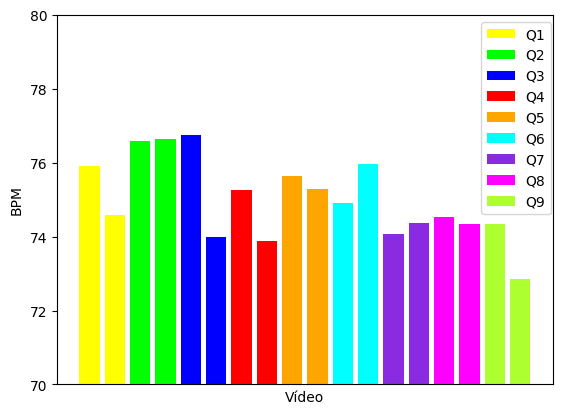

In [22]:
## plot global de max_bpm
fig, ax = plt.subplots()
legend_add = []
for i,v_name in enumerate(list_videos):
    clr = clr_select(v_name)
    max_bpm_vid = [dict_bvp[v_name][id]['max_bpm'] for id in dict_bvp[v_name]]
    if clr not in legend_add:
        ax.bar(x=v_name, height=np.mean(max_bpm_vid),color=clr,label=v_name.split('_')[0])
        legend_add.append(clr)
    else:
        ax.bar(x=v_name, height=np.mean(max_bpm_vid),color=clr)

ax.set_ylim([70,80])
#ax.set_title(f"bmp maxim mitja")
ax.set_ylabel('BPM')
ax.set_xlabel('Vídeo')
ax.set_xticks([])
plt.legend(bbox_to_anchor = (1.01, 1))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


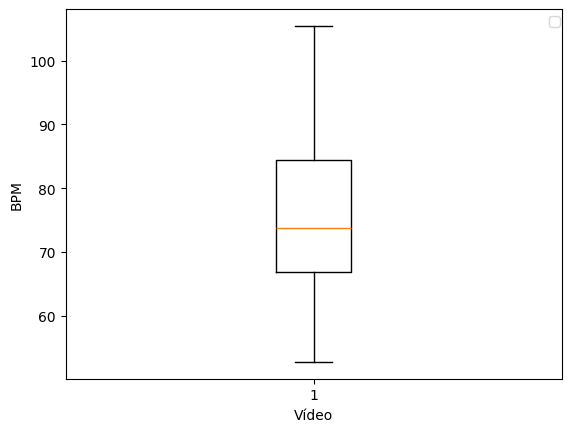

In [35]:
## histograma 1 video
bins = range(40,120,5)

v_name = 'Q1_1'

fig, ax = plt.subplots()

clr = clr_select(v_name)
max_bpm_vid = [dict_bvp[v_name][id]['max_bpm'] for id in dict_bvp[v_name]]
ax.boxplot(max_bpm_vid)


#ax.set_xlim([40,120])
#ax.set_title(f"bmp maxim mitja")
ax.set_ylabel('BPM')
ax.set_xlabel('Vídeo')

plt.legend(bbox_to_anchor = (1.01, 1))
plt.show()

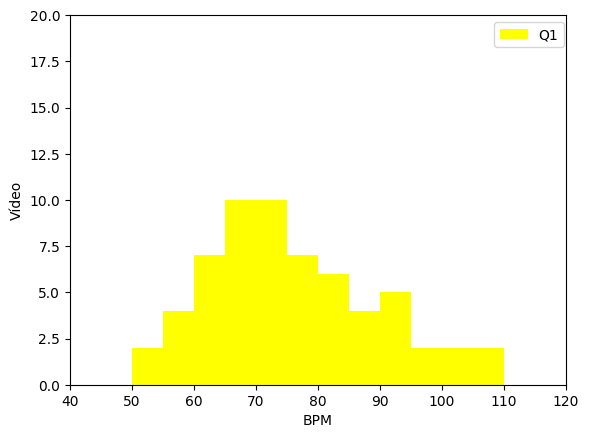

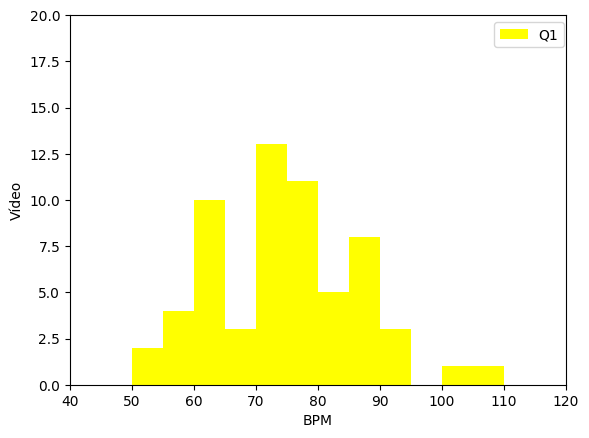

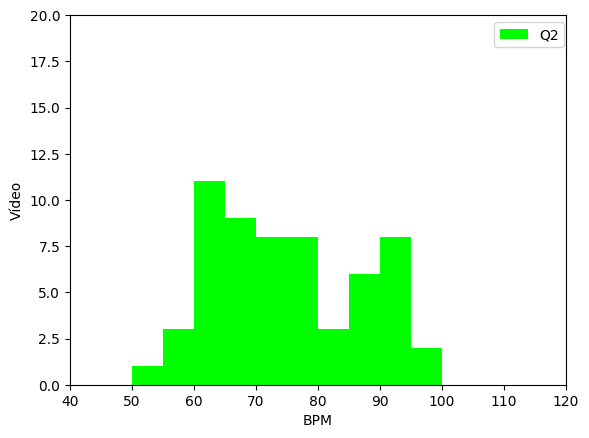

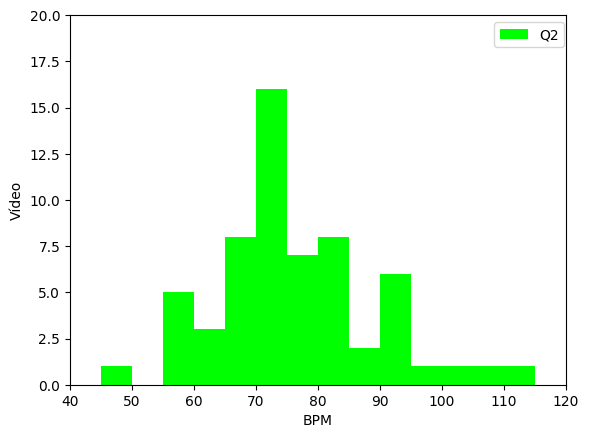

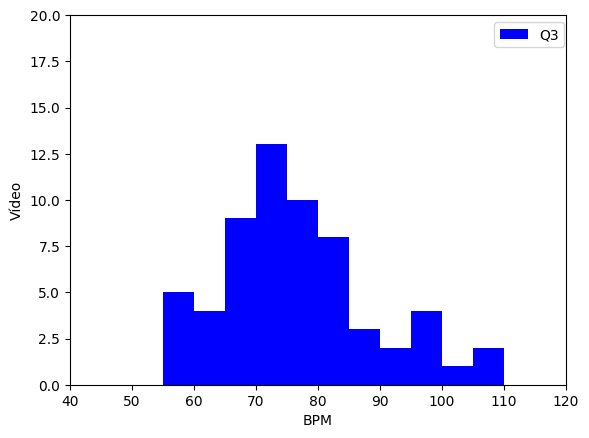

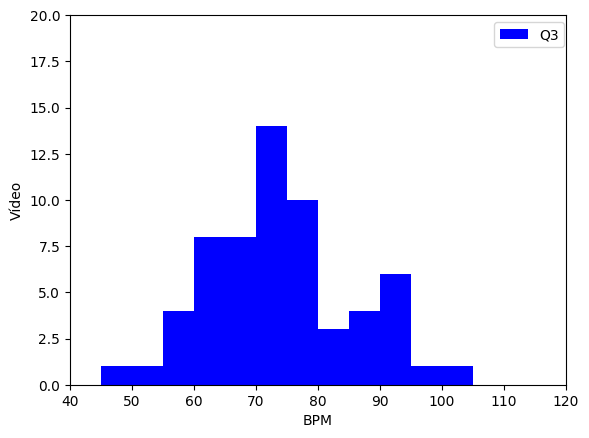

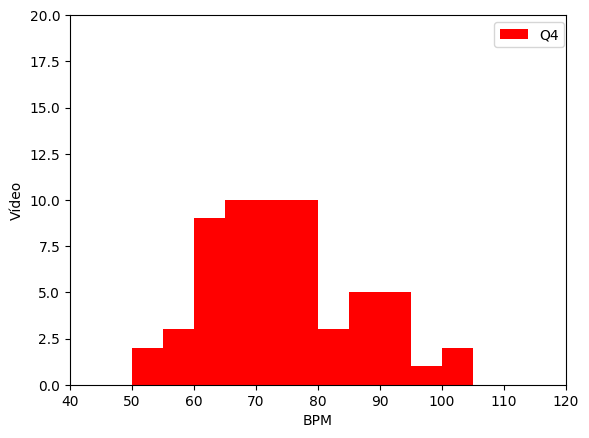

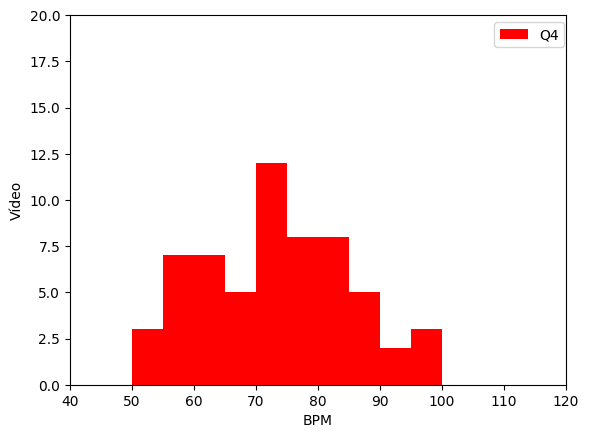

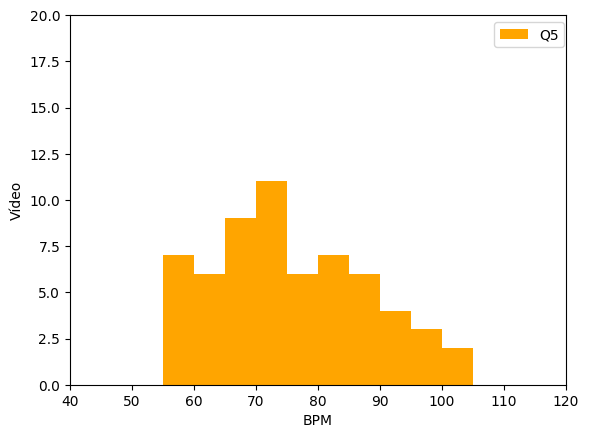

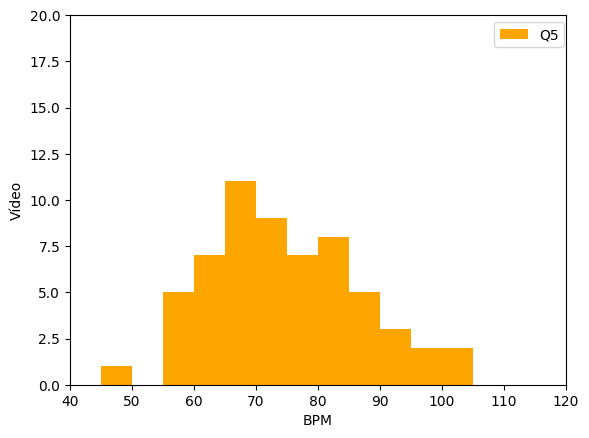

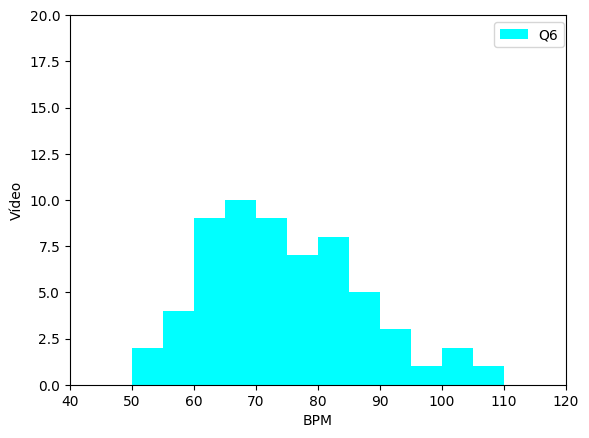

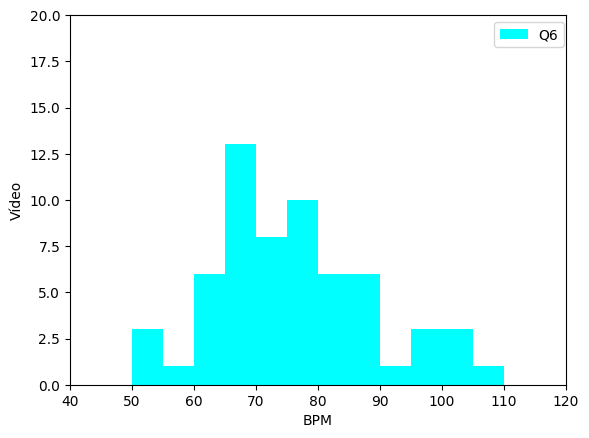

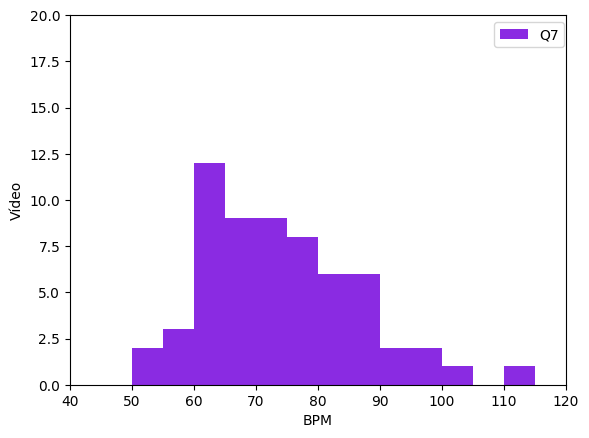

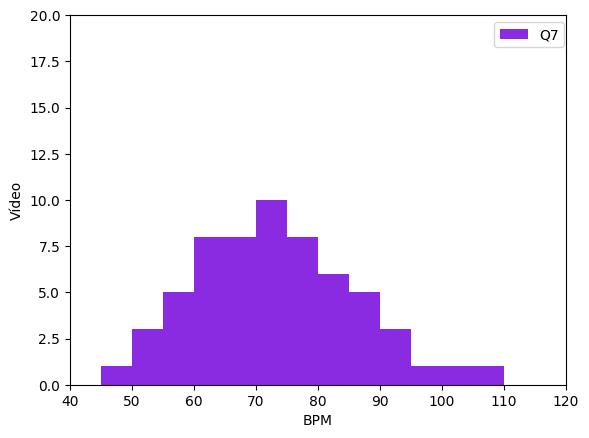

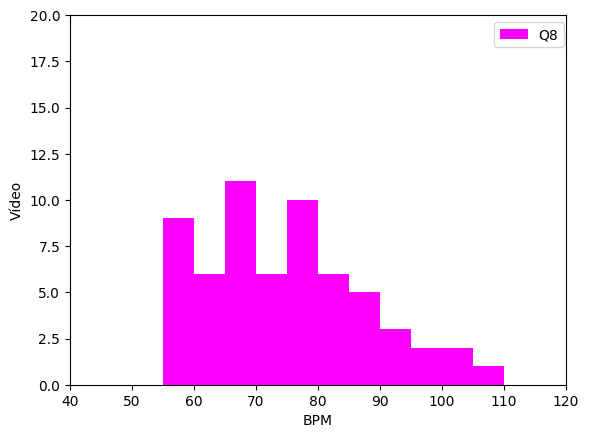

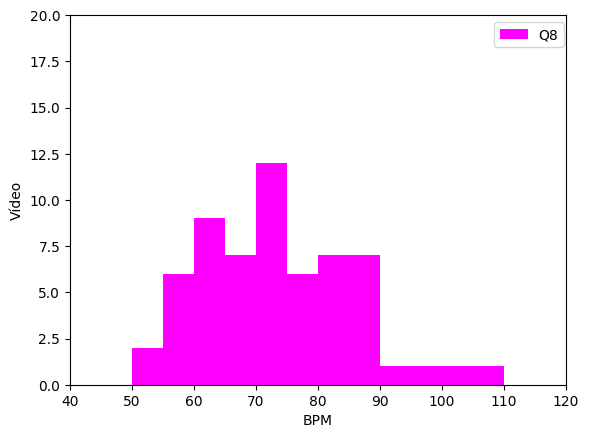

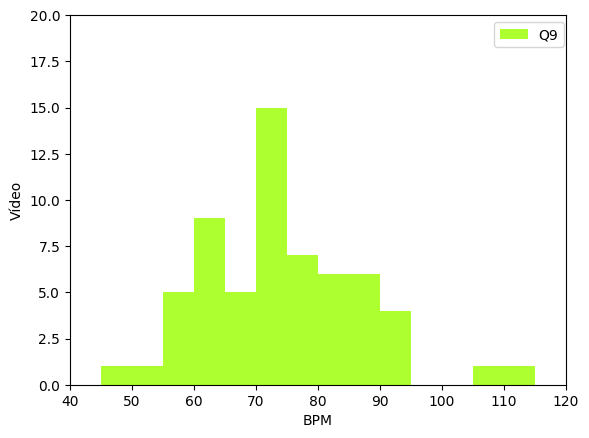

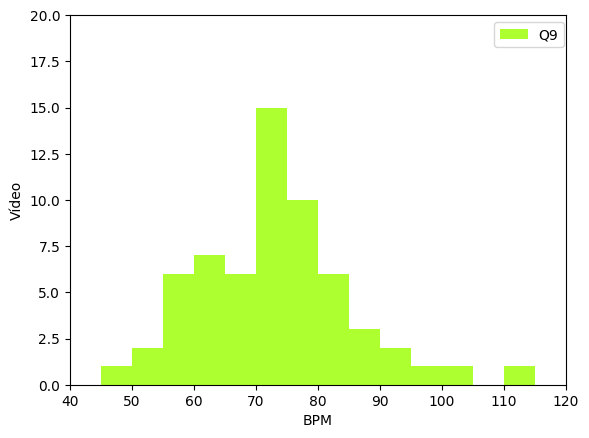

In [150]:
## histograma 1 video
bins = range(40,120,5)

for v_name in list_videos:
    fig, ax = plt.subplots()
    legend_add = []
    clr = clr_select(v_name)
    max_bpm_vid = [dict_bvp[v_name][id]['max_bpm'] for id in dict_bvp[v_name]]
    if clr not in legend_add:
        ax.hist(max_bpm_vid, bins = bins, color=clr, alpha=1, label=v_name.split('_')[0])
        legend_add.append(clr)
    else:
        ax.hist(max_bpm_vid, bins = bins, color=clr)

    ax.set_xlim([40,120])
    ax.set_ylim([0,20])
    #ax.set_title(f"bmp maxim mitja")
    ax.set_xlabel('BPM')
    ax.set_ylabel('Vídeo')
    #ax.set_xticks([])
    plt.legend(bbox_to_anchor = (1.01, 1))
    plt.show()

#### prova 2

In [8]:
## Normalice
## prova 1: - mean
dict_bvp_norm = {}
if True:
    for v_name in list_videos:
        dict_bvp_norm[v_name] = []

    for id in ids:
        max_bpm_pat = [dict_bvp[v_name][id]['max_bpm'] for v_name in list_videos]
        mean_pat = np.mean(max_bpm_pat)

        for v_name in list_videos:
            norm_val = dict_bvp[v_name][id]['max_bpm']-mean_pat
            dict_bvp_norm[v_name].append(norm_val)

## prova 2: - mean / std
if False:
    for v_name in list_videos:
        dict_bvp_norm[v_name] = []

    for id in ids:
        max_bpm_pat = [dict_bvp[v_name][id]['max_bpm'] for v_name in list_videos]
        mean_pat = np.mean(max_bpm_pat)
        std_pat = np.std(max_bpm_pat)

        for v_name in list_videos:
            norm_val = (dict_bvp[v_name][id]['max_bpm']-mean_pat)/std_pat
            dict_bvp_norm[v_name].append(norm_val)

## prova 3: - min / (max-min)
if False:
    for v_name in list_videos:
        dict_bvp_norm[v_name] = []

    for id in ids:
        max_bpm_pat = [dict_bvp[v_name][id]['max_bpm'] for v_name in list_videos]
        mim_pat = np.min(max_bpm_pat)
        max_pat = np.max(max_bpm_pat)

        for v_name in list_videos:
            norm_val = (dict_bvp[v_name][id]['max_bpm']-mim_pat)/(max_pat-mim_pat)
            dict_bvp_norm[v_name].append(norm_val)


print(dict_bvp_norm)


{'Q1_1': [-4.443359375, -3.564453125, -0.927734375, 0.3173828125, 2.5390625, -5.17578125, 8.0078125, 1.3427734375, -1.318359375, -4.4921875, 3.515625, -0.8056640625, 1.0498046875, 0.0, 4.1259765625, 0.48828125, 5.6640625, -3.1982421875, -1.3916015625, 2.5390625, 2.001953125, 1.8310546875, 0.1220703125, 1.66015625, -4.5166015625, -6.494140625, -3.3935546875, 1.0009765625, -7.3486328125, -2.05078125, 7.470703125, -0.4638671875, -1.7822265625, 0.1708984375, 0.3662109375, -1.3916015625, -0.6103515625, -0.9033203125, 28.1005859375, 10.2783203125, 7.0556640625, 1.416015625, 2.5634765625, 0.0, -1.0986328125, 1.513671875, -1.416015625, -1.4404296875, 0.5126953125, -3.4912109375, -4.638671875, 10.2783203125, 0.9765625, -1.0986328125, 3.3203125, 12.20703125, -0.68359375, -1.123046875, 2.5634765625, -2.001953125, 1.66015625], 'Q1_2': [-0.927734375, 3.466796875, -0.927734375, 0.3173828125, -0.9765625, 1.85546875, 11.5234375, 4.8583984375, -1.318359375, 0.78125, 1.7578125, 0.9521484375, -2.46582031

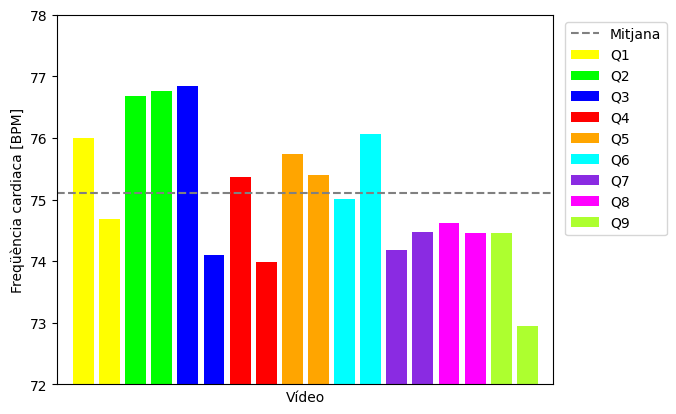

In [15]:
## plot global de max_bpm
fig, ax = plt.subplots()
legend_add = []
for i,v_name in enumerate(list_videos):
    clr = clr_select(v_name)
    max_bpm_vid = dict_bvp_norm[v_name]
    if clr not in legend_add:
        ax.bar(x=v_name, height=np.mean(max_bpm_vid)+75.1,color=clr,label=v_name.split('_')[0])
        legend_add.append(clr)
    else:
        ax.bar(x=v_name, height=np.mean(max_bpm_vid)+75.1,color=clr)
ax.plot([-1,18], [75.1]*2,'--',color='grey',label='Mitjana')

ax.set_ylim([72,78])
ax.set_xlim([-1,18])
#ax.set_title(f"bmp maxim mitja")
ax.set_ylabel('Freqüència cardiaca [BPM]')
ax.set_xlabel('Vídeo')
ax.set_xticks([])
plt.legend(bbox_to_anchor = (1.01, 1))
plt.show()

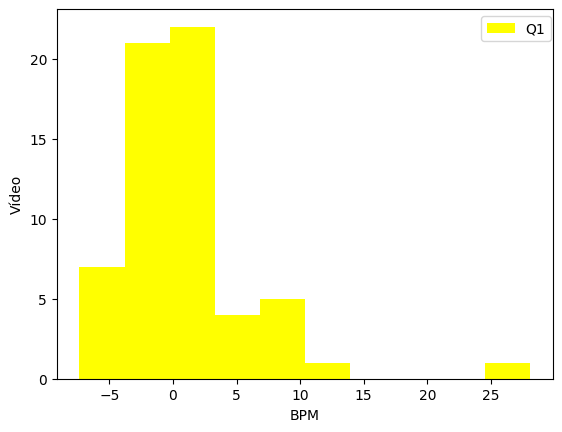

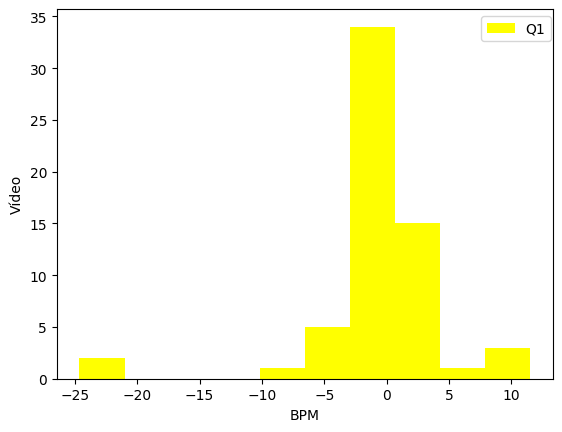

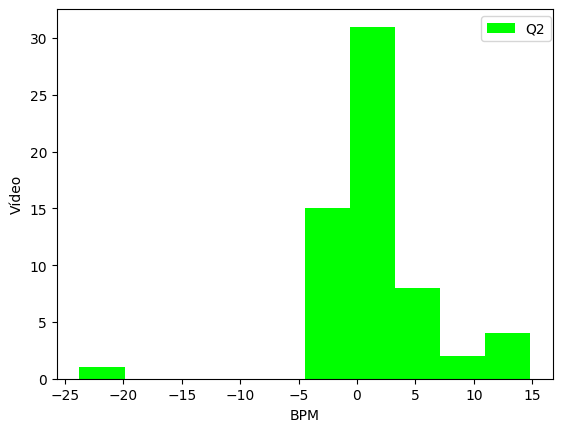

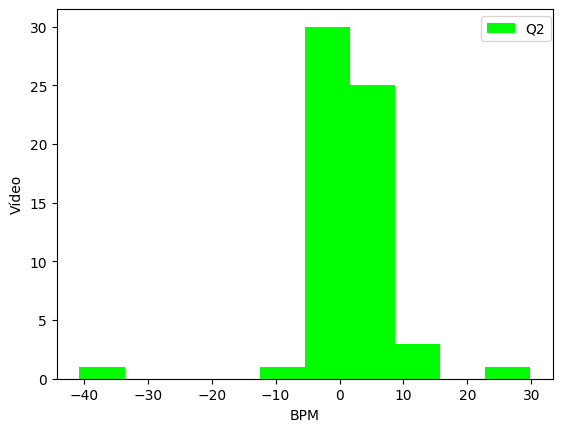

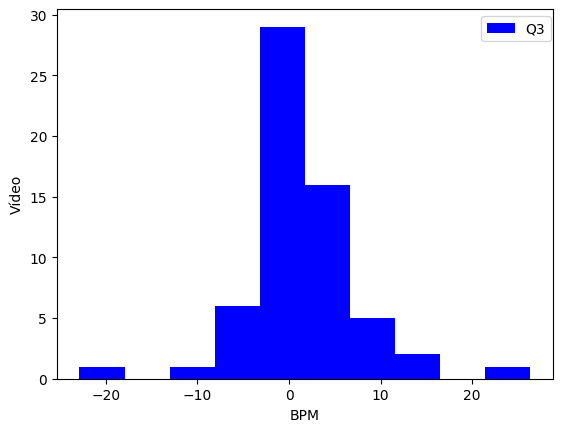

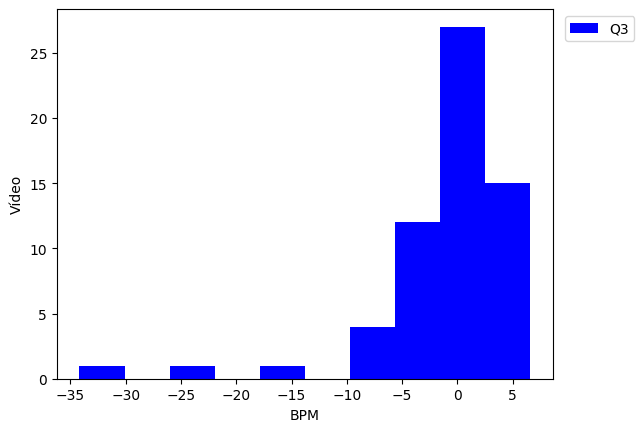

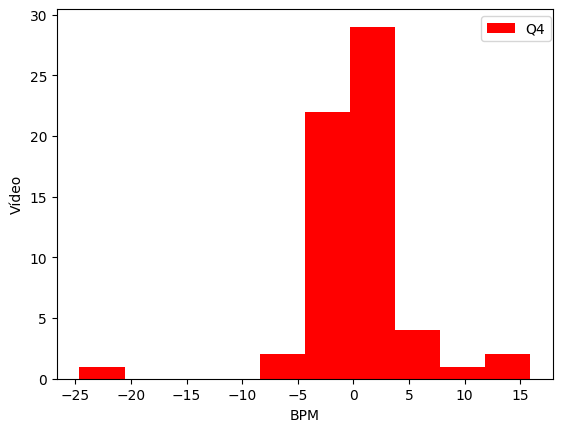

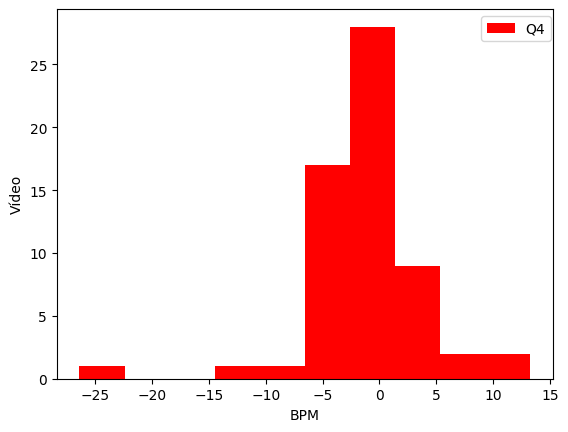

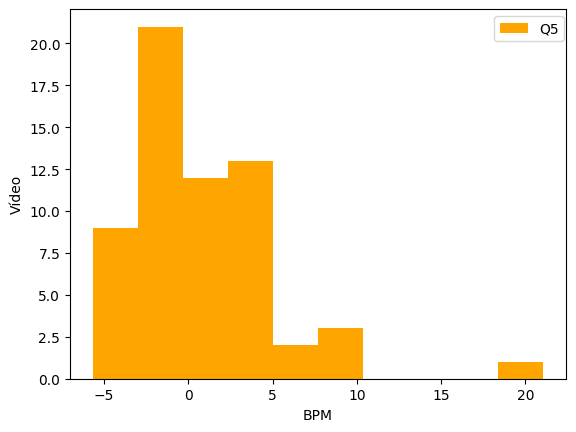

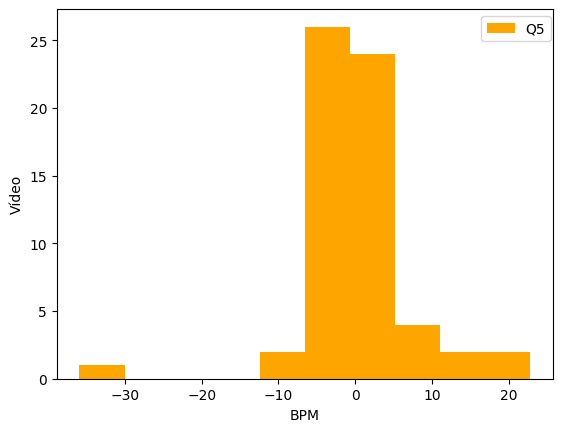

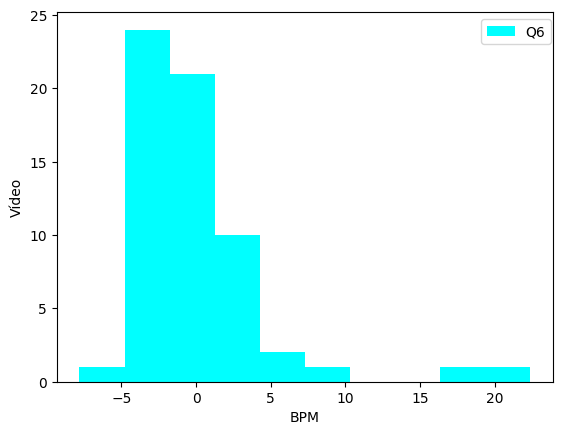

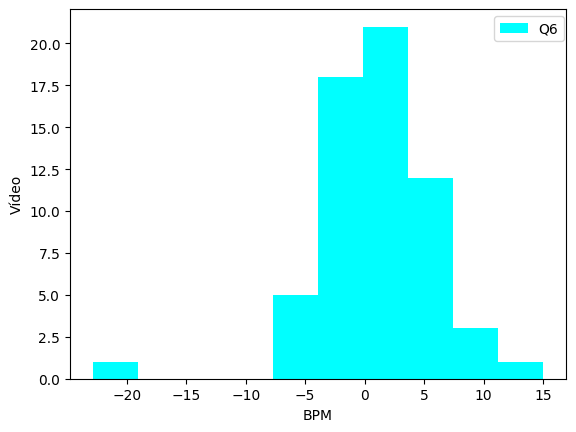

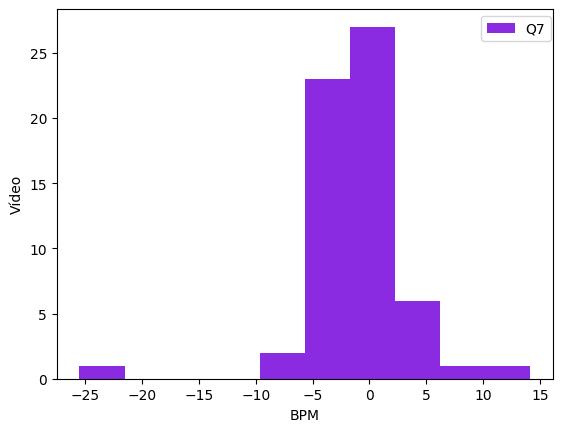

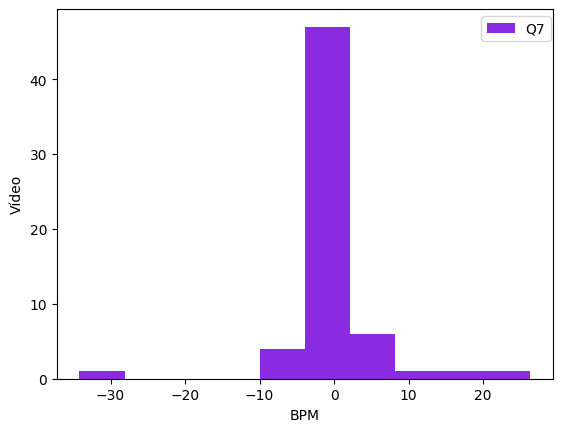

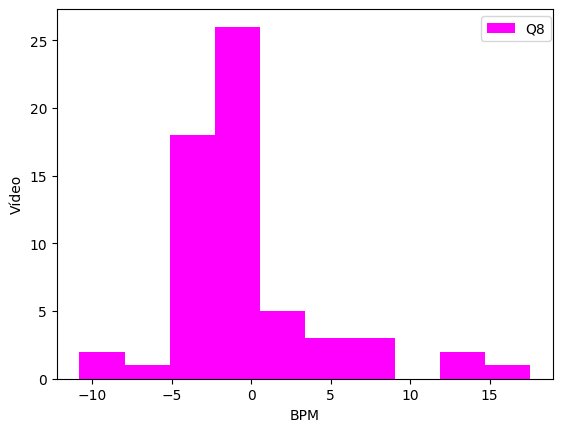

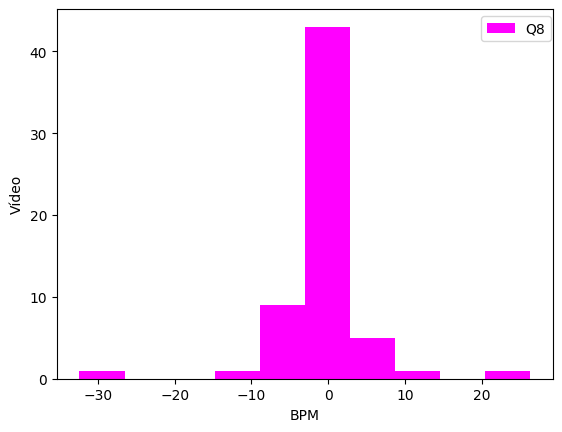

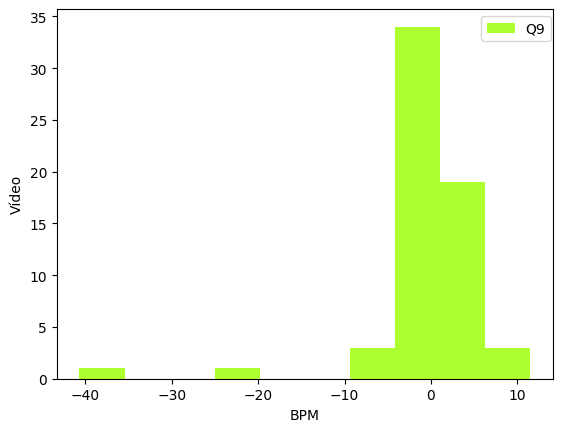

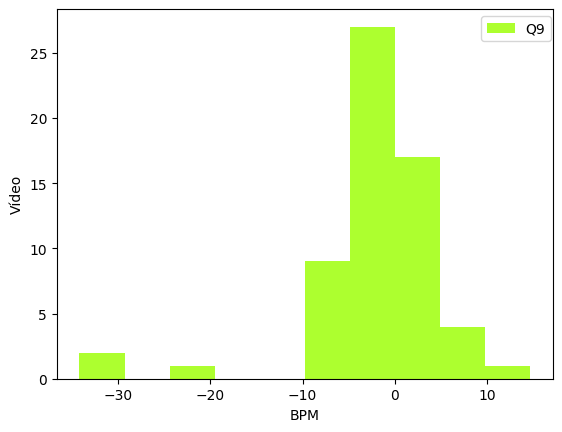

In [173]:
## histograma 1 video
#bins = range(40,120,5)

for v_name in list_videos:
    fig, ax = plt.subplots()
    legend_add = []
    clr = clr_select(v_name)
    max_bpm_vid = dict_bvp_norm[v_name]
    if clr not in legend_add:
        ax.hist(max_bpm_vid, bins = 10, color=clr, alpha=1, label=v_name.split('_')[0])
        legend_add.append(clr)
    else:
        ax.hist(max_bpm_vid, bins = bins, color=clr)

    #ax.set_xlim([40,120])
    #ax.set_ylim([0,20])
    #ax.set_title(f"bmp maxim mitja")
    ax.set_xlabel('BPM')
    ax.set_ylabel('Vídeo')
    #ax.set_xticks([])
    plt.legend(bbox_to_anchor = (1.01, 1))
    plt.show()

#### prova2

In [145]:
## crear data
#dict_bvp[v_name][id]['max_bpm']
maxbpm_separate_dict = {}

for v_name in list_videos:
    aux_dict = {-2:[],-1:[],0:[],1:[],2:[]}
    for i,id in enumerate(ids):
        aux_dict[dict_va[v_name]['a'][i]].append(dict_bvp[v_name][id]['max_bpm'])
    print(aux_dict)
    maxbpm_separate_dict[v_name] = aux_dict
    
#print(maxbpm_separate_dict)

{-2: [], -1: [94.921875], 0: [59.765625, 72.0703125, 105.46875, 100.1953125, 68.5546875, 63.28125, 61.5234375, 77.34375], 1: [54.4921875, 73.828125, 52.734375, 91.40625, 75.5859375, 73.828125, 82.6171875, 65.0390625, 68.5546875, 84.375, 75.5859375, 59.765625, 75.5859375, 75.5859375, 73.828125, 58.0078125, 73.828125, 70.3125, 65.0390625, 96.6796875, 63.28125, 61.5234375, 68.5546875, 86.1328125, 68.5546875, 56.25, 77.34375, 66.796875, 86.1328125, 68.5546875], 2: [63.28125, 70.3125, 91.40625, 68.5546875, 82.6171875, 80.859375, 100.1953125, 89.6484375, 72.0703125, 105.46875, 66.796875, 63.28125, 93.1640625, 72.0703125, 61.5234375, 89.6484375, 93.1640625, 80.859375, 84.375, 96.6796875, 73.828125, 77.34375]}
{-2: [], -1: [79.1015625], 0: [65.0390625, 59.765625, 63.28125, 70.3125, 70.3125], 1: [61.5234375, 94.921875, 79.1015625, 89.6484375, 84.375, 82.6171875, 73.828125, 63.28125, 77.34375, 86.1328125, 86.1328125, 100.1953125, 54.4921875, 68.5546875, 72.0703125, 82.6171875, 73.828125, 61.5234

In [143]:
for i in dict_va:
    print(i, dict_va[i]['a'])

Q1_1 [0, 1, 2, 2, 1, 1, 1, 0, 1, 1, 2, 1, -1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 2, 0, 2, 0, 2, 1, 1, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 0, 2]
Q1_2 [2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 0, 0, 1, 0, 2, 2, 1, 2, 2, 2, 0, 1, 2, 1, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, -1, 2, 1, 2, 1, 2, 1, 2, 1]
Q2_1 [1, 2, -1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 0, 1, 1, 0, 0, 1, 2, 2, 1, 2, 0, 2, 2, 1, 0, 1, 2, 2, 0, 1, 1, 2, 0, 0, 2, 2, 1, 1, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 2]
Q2_2 [0, 2, 2, 1, 1, 1, 1, -1, 2, 1, 2, 2, 1, 0, 0, 1, 1, 0, 2, 2, 2, 2, 1, 0, 0, 1, 1, 2, 2, 2, 2, 1, 1, 0, 2, 1, 0, 1, 1, 0, 2, 1, 2, 0, 1, 0, 0, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 0, 2, 2]
Q3_1 [-1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 1, 2, -1, -1, -1, 1, 1, 0, 1, 0, 1, 0, 0, -1, 0, 0, -1, 1, 0, 1, 0, 0, 0, 1, 2, 1, 0, 1, 1, 1, 0, -1, 1, -1, 1, 0, -1, 1, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
Q3_2 [1, 0, 2, 2, 1, 1, 1, -1, 0, 1, 2, 0,

#### EDA

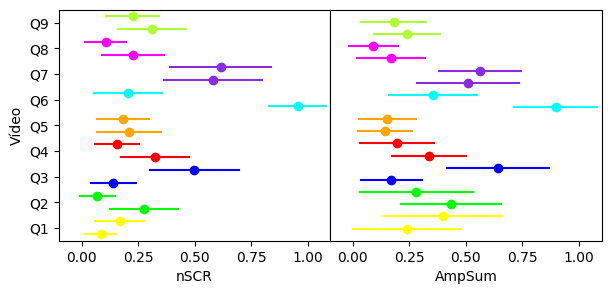

In [108]:
fig, axs = plt.subplots(1,2)
#zona1 = ['Q5_1','Q5_2','Q8_1','Q8_2',]
fig.set_size_inches(7,3)
plt.subplots_adjust(wspace=0.0)

for y, v_name in enumerate(list_videos):
    nSCR_vid = dict_eda[v_name]['nSCR']
    AmpSum_vid = dict_eda[v_name]['AmpSum']
    mean_nSCR = np.mean(nSCR_vid)
    mean_AmpSum = np.mean(AmpSum_vid)
    std_nSCR = np.std(nSCR_vid)
    std_AmpSum = np.std(AmpSum_vid)
    clr = clr_select(v_name)

    axs[0].scatter(mean_nSCR,y,color=clr)
    axs[1].scatter(mean_AmpSum,y,color=clr)
    axs[0].plot([mean_nSCR-std_nSCR,mean_nSCR+std_nSCR],[y]*2,color=clr)
    axs[1].plot([mean_AmpSum-std_AmpSum,mean_AmpSum+std_AmpSum],[y]*2,color=clr)

quadrant_list = [v_name.split('_')[0] for i, v_name in enumerate(list_videos) if i%2==0]
axs[0].set_ylim([-0.5,len(list_videos)-0.5])
axs[1].set_ylim([-1,len(list_videos)])
axs[0].set_yticks(np.array(range(0,len(quadrant_list)))*2+0.5,quadrant_list)
axs[1].set_yticks([])
axs[0].set_xlim([-0.1,1.1])
axs[1].set_xlim([-0.1,1.1])
axs[0].set_xlabel('nSCR')
axs[0].set_ylabel('Vídeo')
axs[1].set_xlabel('AmpSum')

plt.show()